In [1]:
import numpy as np

In [2]:
A = 25
D = 1
K = A * 2**4 / D**3
# https://www.wolframalpha.com/input?i2d=true&i=A*4+%5C%2840%29x_1+%2B+x_2%5C%2841%29+%2B+D+%3D+A*D*4+%2B+Power%5BD%2C3%5D+Divide%5B+1%2C4+*+x_1+*+x_2%5D%5C%2844%29+x_1%3E0%5C%2844%29+x_2%3E0%5C%2844%29+A%3E0%5C%2844%29+D%3E0

In [65]:
# x_1 = ETH, x_2 = stETH
x_1 = D*np.linspace(10,50,1000)/100

In [66]:
## curve invariant
def y_x(A,D, x):
 return 1 / 8 / A * ( A*np.sqrt( 1/x / A**2 * (16*A**2*D**2*x -32*A**2*D*x*x+16*A**2*x*x*x+ 4*A*D**3-8*A*D**2*x+8*A*D*x*x+D**2*x ) )+4*A*D-4*A*x-D )

def get_price(K, x,y):
    return (K + 1/(y**2*x))/(K + 1/(x**2*y))

In [67]:
# x_2 = 1 / 8 / A * ( A*np.sqrt( 1/x_1 / A**2 * (16*A**2*D**2*x_1 -32*A**2*D*x_1*x_1+16*A**2*x_1*x_1*x_1+ 4*A*D**3-8*A*D**2*x_1+8*A*D*x_1*x_1+D**2*x_1 ) )+4*A*D-4*A*x_1-D )

x_2 = y_x(A,D,x_1)

In [68]:
## check correctness of invariant - just put it in invariant's equation from Stableswap WP
max(abs(A * 4 * (x_1+x_2) - D**3/2**2 / (x_1*x_2) + D - A*4*D))

4.263256414560601e-14

Text(0, 0.5, 'x_2')

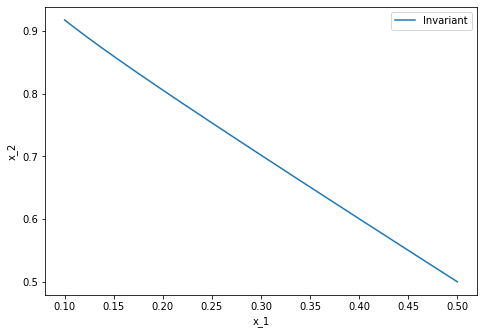

In [69]:
#plot curve invariant
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_axes( [0,0,1,1])
ax.plot( x_1, x_2, label='Invariant')
ax.legend()
ax.set_xlabel("x_1")
ax.set_ylabel("x_2")

In [70]:
# price x_1(x_2)
p = get_price(K, x_1, x_2)

#LP price in x_1
lp_price = x_1/p + x_2

#LP price from virtual price
virtual_price = (x_1+x_2)

lp_virt = np.minimum( virtual_price/p, virtual_price)

Text(0, 0.5, 'Value, in Token 2')

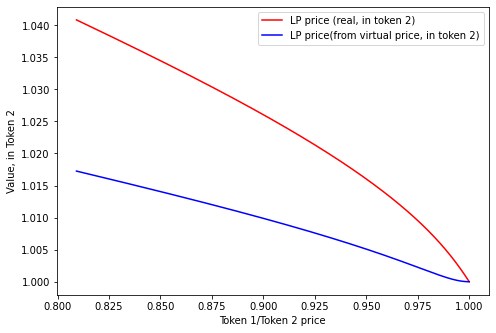

In [71]:


fig = plt.figure()
ax = fig.add_axes( [0,0,1,1])
ax.plot( p, lp_price, color='r', label='LP price (real, in token 2)')
ax.plot( p, lp_virt, color='b', label='LP price(from virtual price, in token 2)')
ax.legend()
ax.set_xlabel("Token 1/Token 2 price")
ax.set_ylabel("Value, in Token 2")

Text(0, 0.5, 'Value, in Token 2')

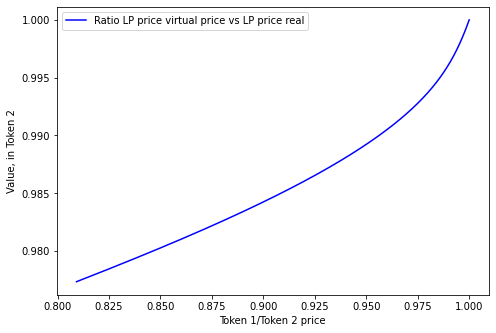

In [72]:
fig = plt.figure()
ax = fig.add_axes( [0,0,1,1])
ax.plot( p, lp_virt/lp_price, color='b', label='Ratio LP price virtual price vs LP price real')
ax.legend()
ax.set_xlabel("Token 1/Token 2 price")
ax.set_ylabel("Value, in Token 2")

In [73]:
lp_virt[np.searchsorted(p, 0.95, side="left")]

1.0050734127853311

Text(0, 0.5, 'Value')

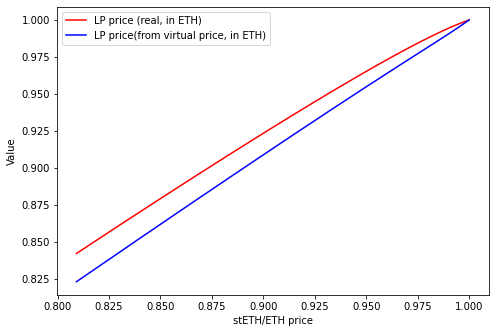

In [74]:

fig = plt.figure()
ax = fig.add_axes( [0,0,1,1])
ax.plot( p, lp_price*p, color='r', label='LP price (real, in ETH)')
ax.plot( p, lp_virt*p, color='b', label='LP price(from virtual price, in ETH)')
ax.legend()
ax.set_xlabel("stETH/ETH price")
ax.set_ylabel("Value")

In [75]:
# slippage calculator

share = 0.03

position_x = x_1 * share
position_y = 0.06 + 0 * x_2 # 
#position_y = x_2 * share

value_before = position_x/p + position_y #value in stETH
x_12 = y_x(A,D, x_2+position_y)

value_after = (x_1 - x_12)/p + position_x/p 
slippage = (value_after - value_before)/value_before

Text(0, 0.5, 'position, stETH')

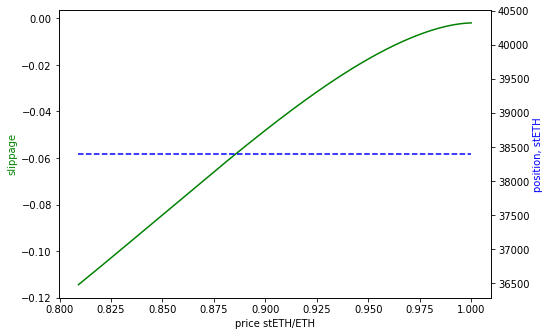

In [76]:
fig = plt.figure()
ax = fig.add_axes( [0,0,1,1])
ax.plot( p, slippage, color='g', label='Slippage')

ax2 = ax.twinx()
ax2.plot(p, 640000*position_y, 'b--')


ax.set_xlabel("price stETH/ETH")
ax.set_ylabel("slippage", color='g')
ax2.set_ylabel('position, stETH', color='b')
#ax.legend()

Text(0, 0.5, 'Value')

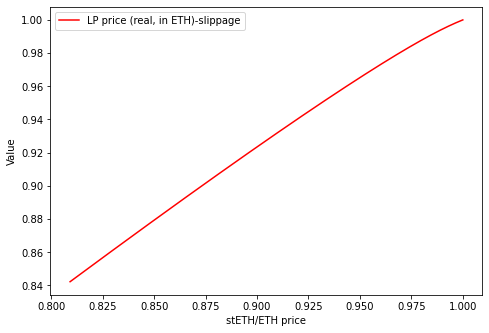

In [77]:

fig = plt.figure()
ax = fig.add_axes( [0,0,1,1])
ax.plot( p, lp_price*p, color='r', label='LP price (real, in ETH)-slippage')
ax.legend()
ax.set_xlabel("stETH/ETH price")
ax.set_ylabel("Value")

In [78]:
slippage[np.searchsorted(p, 0.9, side="left")]

-0.04790683501757092

Text(0, 0.5, 'Value')

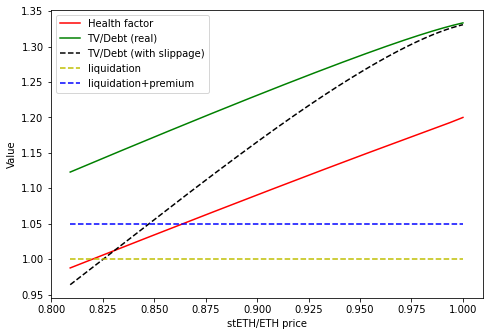

In [82]:

LT = 0.9 
Leverage = 4
fig = plt.figure()
ax = fig.add_axes( [0,0,1,1])

health = lp_virt*p*LT*Leverage/(Leverage-1)
totalvalue_real = lp_price*(p)*Leverage/(Leverage-1) ## calculate what happens if large liquidation first and then ours
totalvalue_slippage = lp_price*(p+slippage)*Leverage/(Leverage-1) ## calculate what happens if large liquidation first and then ours

ax.plot( p, health, color='r', label='Health factor')
ax.plot( p, totalvalue_real, color='g', label='TV/Debt (real)')
ax.plot( p, totalvalue_slippage, 'k--', label='TV/Debt (with slippage)')
ax.plot( p, p * 0 + 1, 'y--', label='liquidation')
ax.plot( p, p * 0 + 1.05, 'b--', label='liquidation+premium')
ax.legend()
ax.set_xlabel("stETH/ETH price")
ax.set_ylabel("Value")

In [18]:
p+slippage

array([-1.41131880e-01, -1.42733670e-01, -1.42993265e-01, -1.41995305e-01,
       -1.39820939e-01, -1.36548302e-01, -1.32252758e-01, -1.27006995e-01,
       -1.20881052e-01, -1.13942310e-01, -1.06255460e-01, -9.78824778e-02,
       -8.88825943e-02, -7.93122859e-02, -6.92252707e-02, -5.86725208e-02,
       -4.77022872e-02, -3.63601379e-02, -2.46890074e-02, -1.27292572e-02,
       -5.18745281e-04,  1.19070962e-02,  2.45151770e-02,  3.72746595e-02,
        5.01568654e-02,  6.31351800e-02,  7.61849541e-02,  8.92834061e-02,
        1.02409524e-01,  1.15543966e-01,  1.28668970e-01,  1.41768252e-01,
        1.54826924e-01,  1.67831397e-01,  1.80769305e-01,  1.93629416e-01,
        2.06401559e-01,  2.19076547e-01,  2.31646110e-01,  2.44102826e-01,
        2.56440059e-01,  2.68651899e-01,  2.80733109e-01,  2.92679071e-01,
        3.04485738e-01,  3.16149589e-01,  3.27667587e-01,  3.39037139e-01,
        3.50256063e-01,  3.61322548e-01,  3.72235129e-01,  3.82992654e-01,
        3.93594262e-01,  